In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataSciece.changeDirOnImportExport setting
import os
try:
    os.chdir(r'C:\Users\kevin\Documents\Workspace\psylit-experiments\src')
    print("Changed cwd:", os.getcwd())
except:
    print("cwd:", os.getcwd())

from IPython.display import display, Markdown, Latex
from collections import *
from statistics import mean
from functools import *
from os import linesep as EOL
from itertools import *
import re
import json
import pathlib
import glob
import math

import spacy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import plotly as py

from models.cascades import *
from viz.cascades import *
from utils.misc import progress

py.offline.init_notebook_mode()
np.random.seed(0)

Changed cwd: C:\Users\kevin\Documents\Workspace\psylit-experiments\src


In [78]:
plt.rcParams['figure.figsize'] = 16,10

In [3]:
ROOT = pathlib.Path().resolve()
DATA_ROOT = ROOT.parent  / 'data' / 'processed' / 'train'
print(ROOT)
print(DATA_ROOT)

C:\Users\kevin\Documents\Workspace\psylit-experiments\src
C:\Users\kevin\Documents\Workspace\psylit-experiments\data\processed\train


In [4]:
data_files = list(glob.glob(str(DATA_ROOT / '*' / '*.csv.zip')))
f = data_files[2]
print(f)
raw_casc = Cascades.from_csv(f)
raw_casc

C:\Users\kevin\Documents\Workspace\psylit-experiments\data\processed\train\0\EN_1778_Burney,Fanny_Evelina_Novel.csv.zip


neg  L_arousal  L_valence  L_dominance  L_positive  \
Subject     t                                                            
NARRATOR    4         0          0          1            1           0   
            26        0          1          1            1           1   
            57        0          0          1            0           0   
            86        0          1          1            1           0   
            87        0          1          1            1           1   
...                 ...        ...        ...          ...         ...   
sir clement 183450    0          1          1            1           1   
            183454    0          0          1            1           0   
            183463    0          0          0            0           0   
            183465    0          0          1            1           0   
            183467    0          1          1            1           1   

                    L_negative  L_sadness  L_fear  L_anger  L_joy  ...  \
Subject     t                                                      ...   
NARRATOR    4                0          0       0        0      0  ...   
            26               0          0       0        0      1  ...   
            57               0          0       0        0      0  ...   
            86               0          0       0        0      0  ...   
            87               0          0       0        0      1  ...   
...                        ...        ...     ...      ...    ...  ...   
sir clement 183450           0          0       0        0      1  ...   
            183454           0          0       0        0      0  ...   
            183463           1          0       0        0      0  ...   
            183465           0          0       0        0      0  ...   
            183467           0          0       0        0      1  ...   

                    L_trust  L_disgust  L_surprise  R_agent_environment  \
Subject     t                                                             
NARRATOR    4             0          0           0                    1   
            26            1          0           1                    1   
            57            0          0           0                    1   
            86            0          0           0                    1   
            87            0          0           0                    1   
...                     ...        ...         ...                  ...   
sir clement 183450        1          0           0                    1   
            183454        0          0           0                    0   
            183463        0          0           0                    1   
            183465        0          0           0                    1   
            183467        1          0           1                    1   

                    R_agent_person  R_agent_subject  R_patient_environment  \
Subject     t                                                                
NARRATOR    4                    0                0                      1   
            26                   0                0                      1   
            57                   0                0                      1   
            86                   0                0                      1   
            87                   0                0                      1   
...                            ...              ...                    ...   
sir clement 183450               0                0                      1   
            183454               1                0                      1   
            183463               0                0                      1   
            183465               0                0                      1   
            183467               0                0                      1   

                    R_patient_person  R_patient_subject  R_unknown  
Subject     t                     

In [5]:
def features_transform(casc):
    keep_single = ['neg', 'R_unknown']
    #name_fmt=lambda src, dst: f"{src[2:]} {dst[2:]}".replace('_',' ').title())
    casc = casc.pair(casc.match_cols(lambda c: c.startswith('R_') and c not in keep_single),
                     casc.match_cols(lambda c: c.startswith('L_') and c not in keep_single),
                     keep_single=keep_single)
    casc.rename_cols(lambda c: c.replace('R_','').replace('L_','').title())
    casc.split_cols()

    def to_psych_categ(col_tuple):
        role, ent, feat = col_tuple
        if not ent and not feat:
            return ('Other_'+ role)
        elif (role, ent) == ('Agent', 'Subject'):
            return ('Response_'+ feat)
        else:
            return ('Stimulus_'+ feat)

    casc = casc.group_columns(to_psych_categ, 'any')
    casc.split_cols()
    casc.set_column_levels(['Category', 'Feature'])
    casc.remove_cols([
        ('Response', 'Positive'),
        ('Response', 'Negative'),
        ('Stimulus', 'Positive'),
        ('Stimulus', 'Negative'),
        ('Other', 'Neg'),
    ])
    return casc

casc = features_transform(raw_casc)

In [6]:
display(Markdown("""## Average frequency per sample"""))
print(f"{len(casc.subjects)} subjects")
print(f"{casc.n_rows} data points ({casc.n_rows / len(casc.subjects)} / subject)")

casc.casc.groupby(level='Subject').sum().mean()

## Average frequency per sample

16 subjects
484720 data points (30295.0 / subject)


Category  Feature     
Other     Unknown           562.0000
Response  Anger              28.3750
          Anticipation       61.3125
          Arousal           201.4375
          Disgust            16.1250
          Dominance         331.6250
          Fear               38.3750
          Joy                45.6250
          Sadness            42.8750
          Surprise           34.3750
          Trust              66.1875
          Valence           388.3750
Stimulus  Anger            2351.9375
          Anticipation     4549.9375
          Arousal         14457.8125
          Disgust          1762.9375
          Dominance       23250.6250
          Fear             3207.9375
          Joy              3574.0000
          Sadness          3362.8125
          Surprise         2679.8125
          Trust            5056.9375
          Valence         26884.3125
dtype: float64

In [134]:
import pyinform
from collections import Iterable
from utils.misc import progress

BE_NAME = '$H(k)$'
B = casc.batch_single_measure('Subject', pyinform.blockentropy.block_entropy, BE_NAME, ks=range(1, 25, 3), win_size=1)
B

TypeError: batch_single_measure() got an unexpected keyword argument 'win_size'

In [122]:
Bagg = B.groupby(['Category', 'Feature', 'k']).agg(['mean', 'std'])
Bagg

$H(k)$          
                          mean       std
Category Feature k                      
Other    Unknown 1    0.133225  0.000000
                 4    0.493833  0.000000
                 7    0.833951  0.000000
                 10   1.159671  0.000000
                 13   1.469898  0.000000
...                        ...       ...
Stimulus Valence 10   5.054387  0.001715
                 13   6.520416  0.002201
                 16   7.913177  0.002676
                 19   9.198628  0.003159
                 22  10.334806  0.003613

[184 rows x 2 columns]

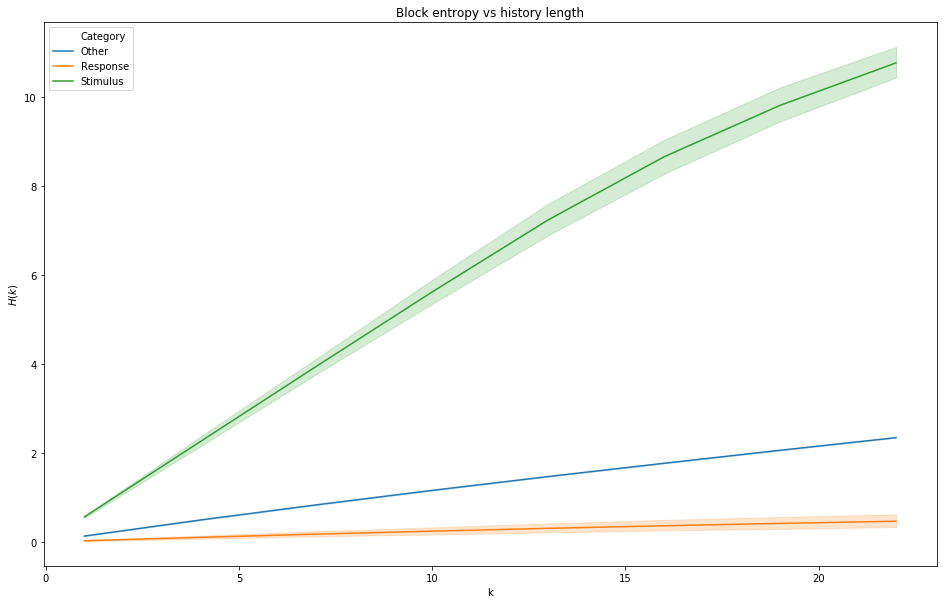

In [123]:
#fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=B, x='k', y=BE_NAME, hue='Category')
plt.title('Block entropy vs history length')
plt.show()

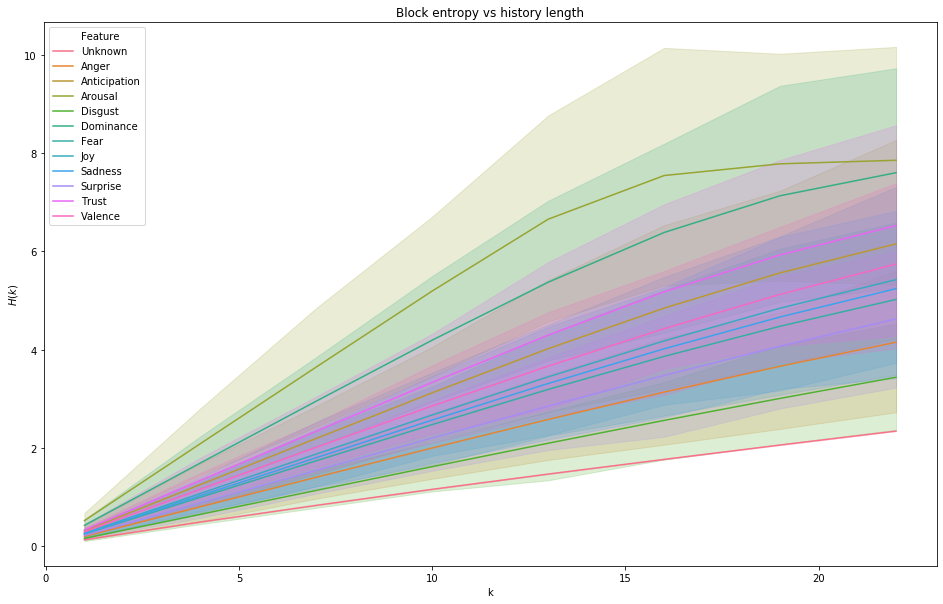

In [124]:
sns.lineplot(data=B, x='k', y=BE_NAME, hue='Feature')
plt.title('Block entropy vs history length')
plt.show()

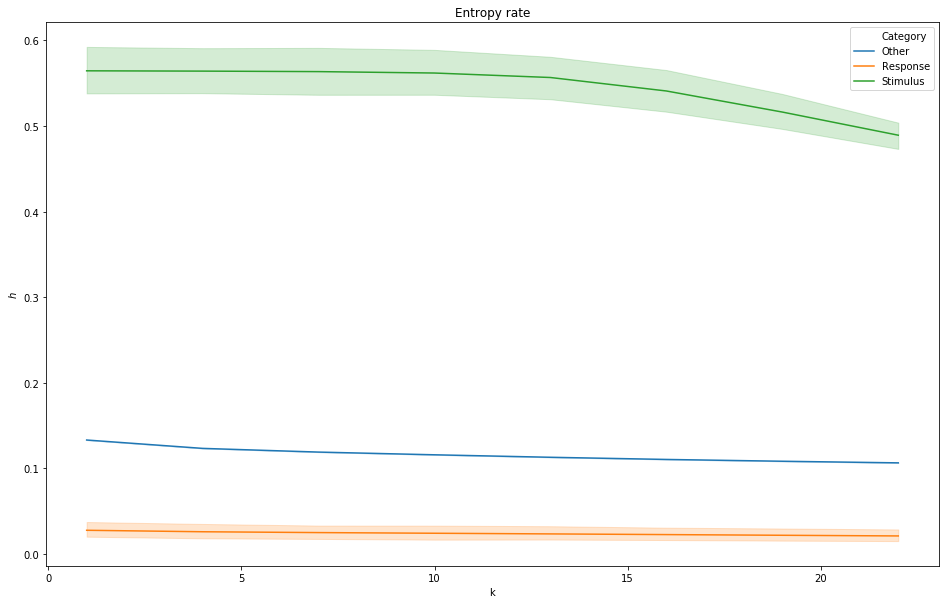

In [130]:
ER_NAME = '$h$'
EE_NAME = '$\eta$'
B[ER_NAME] = B[BE_NAME] / B['k']
B[EE_NAME] = B[BE_NAME] - B['k']*B[ER_NAME]
sns.lineplot(data=B, x='k', y=ER_NAME, hue='Category')
plt.title('Entropy rate')
plt.show()

In [131]:
Bmax = B[B.k == B.k.max()].sort_values(by=ER_NAME)
Bmax.head()

,Subject,Category,Feature,k,$H(k)$,$h$,$\eta$
1143,ma'am,Response,Disgust,22,0.000000,0.000000,0.0
1695,mr. smith,Response,Disgust,22,0.011865,0.000539,0.0
1511,mr. macartney,Response,Disgust,22,0.011865,0.000539,0.0
1119,ma'am,Response,Anger,22,0.011865,0.000539,0.0
2407,orville,Response,Anger,22,0.021034,0.000956,0.0


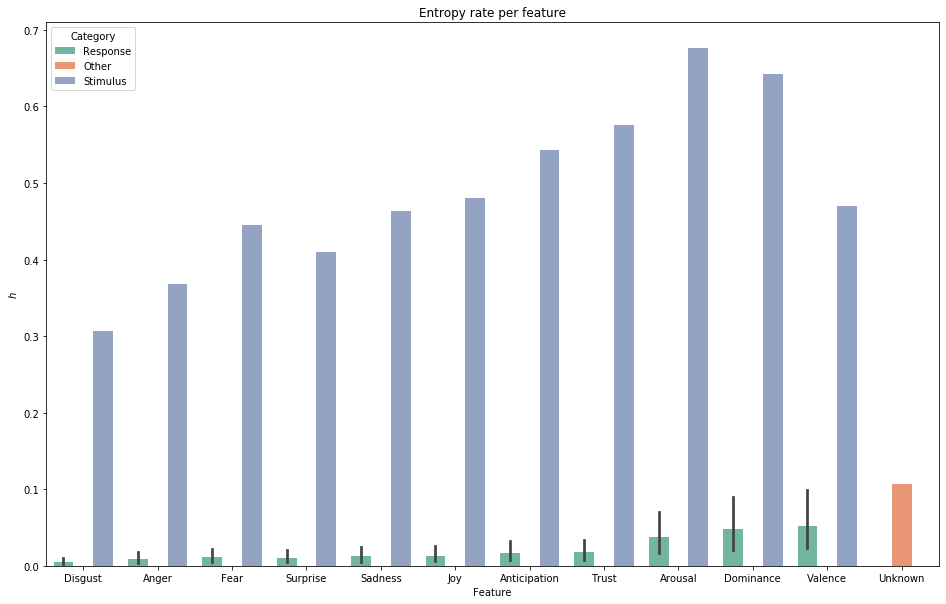

In [132]:
plt.title('Entropy rate per feature')
sns.barplot(x='Feature', hue='Category', y=ER_NAME, data=Bmax, palette="Set2")

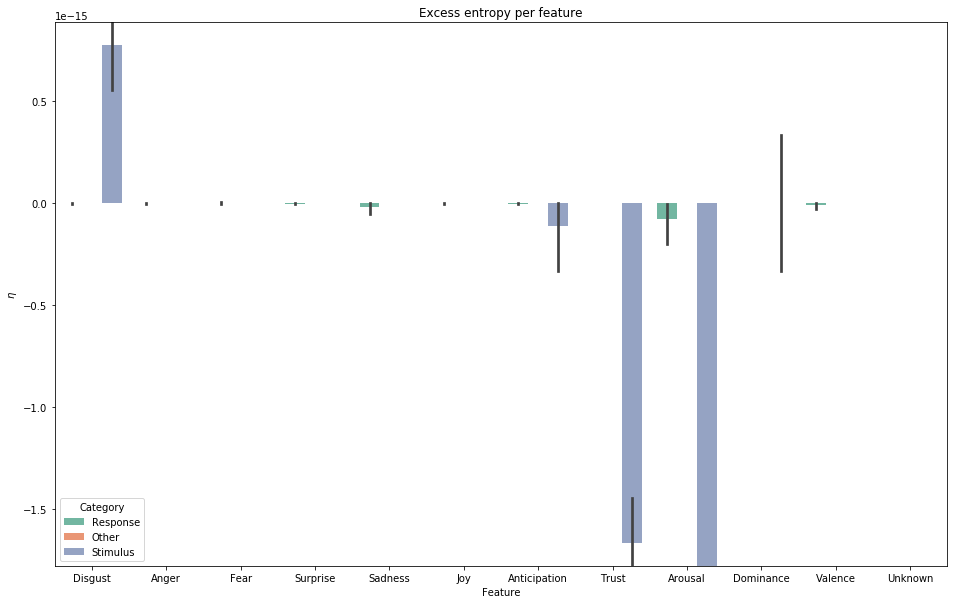

In [133]:
plt.title('Excess entropy per feature')
sns.barplot(x='Feature', hue='Category', y=EE_NAME, data=Bmax, palette="Set2")

In [ ]:
data_files = list(glob.glob(str(DATA_ROOT / '*' / '*.csv.zip')))#[:3]
parsed_cascs = [Cascades.from_csv(f) for f in progress(data_files)]
df_full = MultiCascades.from_cascades(parsed_cascs,
                                      document_values=[pathlib.Path(f).stem.split('.')[0] for f in data_files])


In [ ]:
%%time
casc_full = features_transform(df_full)
casc_full

In [ ]:
B = batch_single_measure(casc, 'Subject', pyinform.blockentropy.block_entropy, BE_NAME, ks=range(1, 25, 3))


In [ ]:
##### SNIPPETS

## int to str/categorical
casc.casc.replace({0:'0',1:'1'}).astype('str')#.astype('category')

## group cascades into symbols
def casc_to_str_seq(casc):
    return pd.Series([
        ''.join(map(str, t))
        for t in casc.replace({0:'0',1:'1'}).astype('str').itertuples(index=False)
    ], index=casc.index)
symb = casc.casc.groupby(level='Subject', group_keys=False).apply(casc_to_str_seq)
symb_int = symb.astype('category').cat.codes#.T['NARRATOR','4']

## generate multiple initial conditions
all_series = np.array([casc.casc.to_numpy() for lbl, g in symb_int.groupby(level='Subject', group_keys=False)])
all_series.shape
pd.Series(series).value_counts()

In [ ]:
plot_dt(df_full)

In [ ]:
from pyinform import transferentropy as te

def transfer_entropies(casc, source_cols=None, destination_cols=None, traj_col=None, **kwargs):
    all_cols = list(casc.columns)
    source_cols = source_cols or all_cols
    destination_cols = destination_cols or all_cols
    
    rows = []
    for sc in source_cols:
        row = {'source': sc, 
               **{dc:te.transfer_entropy(casc[sc], casc[dc], **kwargs) for dc in destination_cols }}
        rows.append(row)
    df = pd.DataFrame(rows)
    df.set_index('source', inplace=True, verify_integrity=True)
    return df


k = 1
T = transfer_entropies(casc.casc, k=k)
T

In [ ]:
casc = pairs_casc.copy()
response_ident = 'Agent Subject'
stim_prefix = "[S] "
resp_prefix = "[R] "
new_names = {
    c: resp_prefix+c.replace(response_ident, '') if c.startswith(response_ident) else stim_prefix+c 
    for c in casc.columns
}
casc.rename(index=str, columns=new_names, inplace=True)
stim_cols = [c for c in casc.columns if c.startswith(stim_prefix)]
resp_cols = [c for c in casc.columns if c.startswith(resp_prefix)]
#casc.columns = pd.MultiIndex.from_tuples(
#    tuple([('Response' if c.startswith('Agent Subject') else 'Stimulus'), *c.split()][::-1])
#    for c in casc.columns
#)
#casc.T.groupby(level=[3,0]).any().astype(int).T


In [ ]:
import plotly as py
import plotly.graph_objs as go

def get_traces(casc):
    ent_casc_cols = [c for c in casc.columns if not c.startswith('L_')]
    for ecol in ent_casc_cols:
        if ecol not in casc.columns:
            print('Ignoring col', ecol)
            continue
        mask = casc[lex_cols][casc[ecol] == 1] == 1
        trace_data = [(c, mask.index[mask[c]]) for c in lex_cols]
        #trace_data = np.array([[v.to_numpy(), [k]*len(v)] for k, v in trace_data.items()])
        #print(trace_data.shape)
        #return trace_data
        x = np.concatenate([idx.to_numpy() for c, idx in trace_data])
        y = np.concatenate([[c]*len(idx)   for c, idx in trace_data])
        yield go.Scattergl({
            "x": x,
            "y": y, 
            "marker": {"opacity": 0.75}, 
            "hoverinfo": "text",
            #"text": txt,
            "mode": "markers", 
            "name": ecol, 
            "type": "scatter"
        })
        
traces = list(get_traces(casc))
layout = {"title": "", 
          "xaxis": {"title": "", }, 
          "yaxis": {"title": ""}}

fig = go.Figure(data=traces)
py.offline.iplot(fig)

In [ ]:
from scipy.stats import ttest_ind
    
ttest_ind(
    casc.loc[casc['patient_subject'] == 1, lex_cols],
    casc[lex_cols].mean(),
    #casc.loc[casc['agent_person'] == 1, lex_cols],
)

In [ ]:
#casc.sum().plot(kind='barh')
sns.barplot(data=casc, x)

In [ ]:
#higher_casc = higher_casc.loc[:, higher_casc.sum() > 15]
casc.sum().sort_values(ascending=False).plot(kind='barh')

In [ ]:
seq_cmap = sns.choose_colorbrewer_palette('sequential')

In [ ]:
import plotly.figure_factory as ff
#x = te_1.index
#y = te_1.destination

#fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text)#, colorscale='Viridis')
sns.heatmap(T, annot=False, cmap=seq_cmap, square=True)
plt.title(f"Transfer entropy (global, k={k})")
plt.show()

In [ ]:
#sns.heatmap((T - T.T), annot=False, cmap='RdBu')#, fmt="d")
sns.clustermap((T - T.T), annot=False, cmap='RdBu', metric='cosine')#, fmt="d")

display(Markdown(f"## Directionality (global, k={k}, subject={subject!r}) : positive = driving, negative = driven"))
plt.show()

In [ ]:
T_sumsq = T.apply(lambda x: x.pow(2).sum())
T_mask = T_sumsq > T_sumsq.mean()
T_core = T.loc[T_mask, T_mask]
sns.clustermap((T_core - T_core.T), annot=False, cmap='RdBu', metric='cosine')#, fmt="d")

display(Markdown(f"## Directionality: relevant subset (global, k={k}, subject={subject!r}) : positive = driving, negative = driven"))
plt.show()

In [ ]:
def group_T(T, func, agg='sum', col_name=None):
    col_name = col_name or agg.title()
    T_core = T.copy().reset_index()
    T_core[col_name] = func(T_core.source)
    T_core = T_core.groupby(col_name).agg(agg)
    T_core = T_core.T.reset_index()
    T_core[col_name] = func(T_core['index'])
    T_core = T_core.groupby(col_name).agg(agg)
    return T_core

In [ ]:
get_ent_role = lambda col: col.str.split(' & ', expand=True)[0]
get_ent = lambda col: col.str.split(' & ', expand=True)[0].str.split('_', expand=True)[1]
get_role = lambda col: col.str.split(' & ', expand=True)[0].str.split('_', expand=True)[0]
get_feat = lambda col: col.str.split(' & ', expand=True)[1]
get_sys = lambda col: np.where(col.str.startswith('[S]'), col, 'Response')#.apply(lambda is_s: [col, 'Response'][is_s]).astype(str) #.str.startswith('Agent Subject').apply(lambda r: ['[Stim] ', '[Resp] '][r]).astype(str) + col.str.split(' & ', expand=True)[1].astype(str)
    #lambda r: ['Stimulus', 'Response'][r[0] == 'agent_subject'] + ' ' + r[1])

def grouped_transfer_entropy_plot(T, T_group_func, grouping_title):
    title = (f"Directionality {grouping_title} (global, k={k}, subject={subject!r}) : positive = driving, negative = driven")
    display(Markdown(f"## {title}"))
    T_core = group_T(T, T_group_func, agg='mean')
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(T_core, dtype=np.bool)
    mask[np.triu_indices_from(mask, +1)] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    g = sns.heatmap((T_core), annot=False, cmap=cmap, mask=mask, square=True, linewidths=.6)
    #g = sns.clustermap((T_core), annot=False, cmap=cmap, mask=mask, metric='cosine', square=True)
    plt.show()

grouped_transfer_entropy_plot(T, get_sys, "per system")
#grouped_transfer_entropy_plot(T, get_ent, "per entity")
#grouped_transfer_entropy_plot(T, get_role, "per role")
#grouped_transfer_entropy_plot(T, get_ent_role, "per entity and role")
#grouped_transfer_entropy_plot(T, get_feat, "per feature")


In [ ]:
from pyinform import blockentropy as be
def get_block_entropies(casc, cols, kmax=10):
    n = len(casc.index)
    
    data = []
    for k in range(1, kmax):
        for c in cols:
            benk = be.block_entropy(casc[c], k=k)
            data.append({'k': k, 'cascade': c, 'block_entropy_k': benk})
    
    return pd.DataFrame(data)

block_entrs = get_block_entropies(higher_casc, all_cols, kmax=30)

In [ ]:
#sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='cascade')
#plt.show()

In [ ]:
block_entrs['block_entropy_k_diff'] = block_entrs.block_entropy_k.diff()
block_entrs[['ent_role','feat']] = block_entrs.cascade.str.split(' & ',expand=True)
block_entrs[['role','entity']] = block_entrs.ent_role.str.split('_',expand=True)
block_entrs['block_entropy_k_ratio'] = block_entrs.block_entropy_k / block_entrs.k
block_entrs['block_entropy_k_ratio_diff'] = block_entrs['block_entropy_k_ratio'].diff()
#block_entrs['f'] = block_entrs.cascade.str.split(' & ')[1]

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='ent', ax=axes[0][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='role', ax=axes[0][1])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='ent_role', ax=axes[1][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='feat', ax=axes[1][1])
fig.suptitle('Block entropy vs history length')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='ent', ax=axes[0][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='role', ax=axes[0][1])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='ent_role', ax=axes[1][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='feat', ax=axes[1][1])
fig.suptitle('Block entropy relative to history length')
plt.show()

In [ ]:
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_diff', hue='e')
plt.show()

In [ ]:
from pyinform import activeinfo as ai

def get_local_ais(casc, cols, k=10):
    n = len(casc.index)
    m = len(cols)
    t = np.tile(np.arange(n), m)
    
    lbl = np.repeat(np.array(cols), n)
    a = []
    pad_w = k-1
    a_c = np.ones([n]) * np.nan
    for c in cols:
        a_c[:-k] = ai.active_info(casc[c], k=k, local=True).squeeze()
        a.append(a_c)
    a = np.concatenate(a)
    
    df = pd.DataFrame({'ais': a, 'cascade': lbl, 't':t})
    df[['e','f']] = df.cascade.str.split(' & ',expand=True)
    return df

ais = get_local_ais(higher_casc, all_cols, k=11)
ais

In [ ]:
fig = lambda:go.Figure(
    data=[go.Scattergl(
        x=ais.t,
        y=ais.ais,
        marker=dict(color=ais.f),
        #line=dict(color='rgb(0,100,80)'),
        #line=dict(color=color),
        mode='markers',
        name=dict(color=ais.f),
    )],
)
#py.offline.iplot(fig)
#fig, ax = plt.subplots()
sns.scatterplot(data=ais.groupby('t').mean().reset_index(), x='t', y='ais', hue='e', ax=ax)
#py.offline.plot_mpl(fig)
#ais.groupby('e',.rolling(20, by='t').agg(['mean','min','max'])

In [ ]:
from plotly.colors import DEFAULT_PLOTLY_COLORS
#sns.lineplot(data=ais[ais.t < 200], x='t', y='ais', hue='e')
#plt.show()
ais_ts = ais.groupby('f').rolling(5).agg(['mean', 'min', 'max'])

def filled_plot(data, x, y, group, rolling_size=20, **kwargs):
    
    
    X = data.groupby(group)
    X = X.rolling(rolling_size, on=x)
    X = X.agg({y:['mean', 'min', 'max']})
    X.columns = X.columns.to_flat_index()
    #X.reset_index(level=['e','f'])
    
    
    
    data = [
        p
        for (gname, gframe), color in zip(X.groupby(group), DEFAULT_PLOTLY_COLORS)
        for p in filled_line(gframe, name=gname, color=color)
    ]       
    
    
    #X = X.unstack(['e','f'])
    #X.loc[('agent_environment','L_NRCw_Em_negative'),[('ais','mean')]]
    
    grouped = data.groupby(group)
    rolled = grouped.rolling(rolling_size)
    agg = rolled.agg({'t': 'mean', 'ais':['mean', 'min', 'max']})
    agg.columns = agg.columns.to_flat_index()
    
    trend = agg['ais', 'mean']
    x = agg['t', 'mean']
    x_rev = x.iloc[::-1]
    y = ['ais', 'mean']
    y_lb = ['ais', 'min']
    y_ub = ['ais', 'max']
    
    def filled_line(frame, color, name=None, **kwargs):
        
        filled = lambda:go.Scattergl(
            x=x + x.iloc[::-1],
            y=pd.concat([y['min'], y['max']]),
            fill='tozerox',
            fillcolor=color,
            #line=dict(color='rgba(255,255,255,0)'),
            #showlegend=False,
            opacity=0.2,
            name=name,
            **kwargs,
        )
        return [
            #filled,
            go.Scattergl(
                x=x,
                y=y['mean'],
                #line=dict(color='rgb(0,100,80)'),
                line=dict(color=color),
                mode='lines',
                name=name,
                **kwargs,
            ),
        ] 
    
    return go.Figure(
        #data=data,
        #layout=layout,
        data=[
            p
            for (gname, gframe, win_), color in zip(grouped, DEFAULT_PLOTLY_COLORS)
            for p in filled_line(gframe, x=x, y=y, name=gname, color=color)
        ]
    )
    
#fig = filled_plot(ais_ts, x='t', y='ais', group='cascade')

#fig = filled_plot(data=ais[ais.t < 200], x='t', y='ais', group='cascade')
#py.offline.iplot(fig)
#for gn, gf in 
#sns.lineplot(data=ais.rolling(20).mean(), x='t', y='ais', hue='e')
#plt.show()
#sns..plot(x='t', y='ais',kind='line')

rolling_size = 20
grouped = ais.groupby(['e','f'])
rolled = grouped.rolling(rolling_size)
trend = rolled['ais'].mean()
x = rolled['t'].mean()
x_rev = x.iloc[::-1]

In [ ]:
X = ais.groupby(['e','f'])
#X = X.reset_index()
X = X.rolling(20, on='t')
trend = X.ais.mean()
X = X.agg({'ais':['mean', 'min', 'max']})
X.columns = X.columns.to_flat_index()
X.apply(lambda s: s - trend, axis='columns')
#X = X.unstack(['e','f'])
#X.loc[:,[('ais','mean')]]
#X.reset_index(level)
##['t','mean']
#X['agent_environment', 'L_NRCw_Em_negative']['t','mean']
#g = grouped.rolling(20)
#g.index[:2]#e, f, win = g.index
#g['t','mean']['patient_person', 'L_NRCw_Em_trust']#[['t','mean']]#,'ais']
#for k,x in g.iterrows():
#    print(k,x)
    #print(gf.describe())
#for x in g[[('t', 'mean'), 'ais']]:
    #print(x)
    #continue
    #print(gn)
    #print(gf[[('t', 'mean'), 'ais']].describe())

In [ ]:
#sns.g
g = grouped.rolling(20)
sns.lineplot(data=g.agg({'t': 'mean', 'ais':['mean', 'min', 'max']}), 
             x=('t', 'mean'), y=('ais', 'mean'), hue=g.index)
plt.show()

In [ ]:
sns.lineplot(data=ais, x='t', y='ais')

In [ ]:
py.offline.plot_mpl?

In [ ]:
spacy.util.minibatch?

In [ ]:
list.pop?

In [ ]:
[].append

In [ ]:
[].push

In [ ]:
[].pop

In [ ]:
import spacy
spacy.__version__

In [ ]:
a = []
a.extend((range(3)))
a.extend((range(4,7)))
print(a)
a.pop(0), a.pop(0), a

In [ ]:
doc

In [ ]:
plt

In [ ]:
"{x} {x[1:]}".format(x="hello")

In [ ]:
import sys
sys.cwd

In [ ]:
x = pd.DataFrame({'a': [0,0,0,1,0,2,0,None], 'b': [0,1,0,None,1,2,0,0]})
x#.loc[1:4,:]

In [ ]:

xx = x.astype(bool) * 1
xx = pd.get_dummies(xx, dummy_na=True)
xx.apply(lambda c:c.astype(bool))

In [ ]:
x.apply(lambda c: c.str)

In [ ]:
ents[entity_not_found]#.mention_root.factorize()

In [ ]:
entity_not_found = ents.entity_i.isna()
ents_fixed = ents.copy()
entity_not_found_ids = -ents[entity_not_found].mention_root.factorize()[0]

ents_fixed.loc[entity_not_found, 'entity_i'] = entity_not_found_ids
ents_fixed.entity_i = ents_fixed.entity_i.astype(np.int32)
ents_fixed

In [ ]:
ents_fixed.groupby(['entity_i', 'entity_root','categ']).categ.count()

In [ ]:
ents[ents.mention_root.str.match('my')]

In [ ]:
ents.apply(lambda c: c.dtype)

In [ ]:
pd.__version__

In [ ]:
block_entropy(np.random.random(100).astype(np.int8) % 10, k=1)
#np.arange(100).dtype

In [ ]:
series = lambda: np.random.randint(2**1, size=30_000)
multi = np.array([series() for _ in range(1)]).astype(np.int16)
print(multi.shape, multi.dtype)
for k in range(1,30):
    print(k, block_entropy(multi, k=k))

In [ ]:
np.random.randint?

In [ ]:
c3.n_rows / len(c3.subjects)

In [ ]:
series().dtype

In [ ]:
with open('..\\list_raw_train.txt') as f:
    raw_files = set(pathlib.Path(x.strip()).stem.split('.')[0] for x in f.readlines())
raw_files

In [ ]:
with open('..\\list_interim_train.txt') as f:
    interim_files = set(pathlib.Path(x.strip()).stem.split('.')[0].split('__')[0] for x in f.readlines())
interim_files

In [ ]:
raw_files - interim_files

In [ ]:
with open('..\\list_processed_train.txt') as f:
    proc_files = set(pathlib.Path(x.strip()).stem.split('.')[0].split('__')[0] for x in f.readlines())
proc_files

In [ ]:
interim_files - proc_files